In [194]:
# 2D Lid-driven Cavity
# STREAMFUNCTION-VORTICITY FORMULATION
# Written by Mr A. J. Brierley
# Cranfield University, Bedfordshire, UK
# 03/06/2025

In [195]:
import numpy as np
import time
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams['animation.html'] = 'html5'

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [196]:
start = time.time()

In [197]:
nx = 32
ny = 32
lx = 1.0
ly = 1.0
dx = lx/(nx-1)
dy = ly/(ny-1)

In [198]:
Ut = 3.2

In [199]:
psi0 = np.zeros([nx,ny])
w0 = np.zeros([nx,ny])
u0 = np.zeros([nx,ny])
v0 = np.zeros([nx,ny])

# STREAMFUNCTION BOUNDARY CONDITIONS
psi_wall = 0.0

# VORTICITY BOUNDARY CONDITIONS 
# w0[:,0] = 2.0*(psi_wall - psi0[:,1])/dx/dx                # left wall
# w0[:,-1] = 2.0*(psi_wall - psi0[:,-2])/dx/dx              # right wall
# w0[0,:] = 2.0*(psi_wall - psi0[1,:])/dy/dy                # bottom wall
# w0[-1,:] = 2.0*(psi_wall - psi0[-2,:])/dy/dy - 2.0*Ut/dy  # top wall 

w[1:ny-1,0] = 2.0*(psi_wall - psi[1:ny-1,1])/dx/dx                # left wall
w[1:ny-1,-1] = 2.0*(psi_wall - psi[1:ny-1,-2])/dx/dx              # right wall
w[0,1:nx-1] = 2.0*(psi_wall - psi[1,1:nx-1])/dy/dy                # bottom wall
w[-1,1:nx-1] = 2.0*(psi_wall - psi[-2,1:nx-1])/dy/dy - 2.0*Ut/dy  # top wall

# Corner points
w[0,0] = (w[1,0] + w[0,1])/2.0                      # bottom left corner
w[ny-1,0] = (w[ny-2,0] + w[ny-1,1])/2.0             # top left corner
w[ny-1,nx-1] = (w[ny-2,nx-1] + w[ny-1,nx-2])/2.0    # top right corner
w[0,nx-1] = (w[1,nx-1] + w[0,nx-2])/2.0             # bottom right corner

# Solution storage
psisol = []
psisol.append(psi0)
wsol = []
wsol.append(w0)
usol = []
usol.append(u0)
vsol = []
vsol.append(v0)

In [200]:
# simulation parameters
beta = 1.5
tol = 1e-4
maxIt = 30

t = 0.0  
nu = 0.05 
#dt = min(0.25*dx*dx/v, 4*v/Ut/Ut)
dt = 0.25*dx*dx/nu
tend = 1000*dt
Re = Ut*lx/nu
print('dt =', dt, 's')
print(f'Re = {Re}')

u = usol[-1].copy()
v = vsol[-1].copy()


dt = 0.005202913631633714 s
Re = 64.0


In [201]:
while t < tend:
    
    #------------------------------------
    # STREAMFUNCTION-POISSON EQUATION
    #------------------------------------
    
    it = 0
    err = 1e5
    wn = wsol[-1]
    psi = psisol[-1].copy()
    while err > tol and it < maxIt:
        # psik is used for the sole purpose of calculating the error in one iteration compared to the last
        psik = np.zeros_like(psi)
        psik[1:-1, 1:-1] = psi[1:-1, 1:-1]
        for i in range(1,nx-1):
            for j in  range(1,ny-1):
                rhs = (dx*dy)**2*wn[j,i] + dy**2*(psi[j,i+1]+ psi[j,i-1]) + dx**2*(psi[j+1,i] + psi[j-1,i])
                rhs *= beta/2.0/(dx**2 + dy**2)
                psi[j,i] = rhs + (1 - beta)*psi[j,i]
        err = np.linalg.norm(psi.ravel() - psik.ravel())
        it += 1
        # print(it)
    psisol.append(psi)

    w = np.zeros_like(wn)

    #--------------------
    # 2D VELOCITY FIELD
    #--------------------

    # Internal points
    u[1:ny-1,1:nx-1] = (psi[2:ny,1:nx-1] - psi[0:ny-2,1:nx-1])/(2*dy)
    v[1:ny-1,1:nx-1] = -(psi[1:ny-1,2:nx] - psi[1:ny-1,0:nx-2])/(2*dx)

    # Boundaries
    u[0,1:nx-1] = 0.0     # Bottom wall
    u[ny-1,1:nx-1] = Ut   # Top wall
    u[1:ny-1,0] = 0.0     # Left wall
    u[1:ny-1,nx-1] = 0.0  # Right wall
    v[0,1:nx-1] = 0.0     # Bottom wall
    v[ny-1,1:nx-1] = 0.0   # Top wall
    v[1:ny-1,0] = 0.0     # Left wall
    v[1:ny-1,nx-1] = 0.0  # Right wall

    # Corner points
    u[0,0] = (u[1,0] + u[0,1])/2.0                       # Bottom left 
    u[0,nx-1] = (u[1,nx-1] + u[0,nx-2])/2.0              # Bottom right
    u[ny-1,nx-1] = (u[ny-2,nx-1] + u[ny-1,nx-2])/2.0     # Top right
    u[ny-1,0] = (u[ny-2,0] + u[ny-1,1])/2.0              # Top left
    v[0,0] = (v[1,0] + v[0,1])/2.0                       # Bottom left 
    v[0,nx-1] = (v[1,nx-1] + v[0,nx-2])/2.0              # Bottom right
    v[ny-1,nx-1] = (v[ny-2,nx-1] + v[ny-1,nx-2])/2.0     # Top right
    v[ny-1,0] = (v[ny-2,0] + v[ny-1,1])/2.0              # Top left

    usol.append(u)
    vsol.append(v)

    div = np.zeros([nx,ny])
    # Divergence of velocity
    div[1:ny-1,1:nx-1] = (u[1:ny-1,2:nx] - u[1:ny-1,0:nx-2])/(2*dx) + (v[2:ny,1:nx-1] - v[0:ny-2,1:nx-1])/(2*dy)

    #-------------------------------------
    # 2D VORTICITY TRANSPORT EQUATION
    #-------------------------------------
    
    Cx = -(psi[2:,1:-1] - psi[:-2,1:-1])/2.0/dy * (wn[1:-1,2:] - wn[1:-1,:-2])/2.0/dx
    Cy = (psi[1:-1,2:] - psi[1:-1,:-2])/2.0/dx * (wn[2:,1:-1] - wn[:-2,1:-1])/2.0/dy
    Dx = (wn[1:-1,2:] + wn[1:-1,:-2] - 2.0*wn[1:-1,1:-1])/dx/dx
    Dy = (wn[2:,1:-1] + wn[:-2,1:-1] - 2.0*wn[1:-1,1:-1])/dy/dy

    rhs = Cx + Cy + nu*(Dx + Dy) 
    #rhs = nu*(Dx + Dy) 
    w[1:-1,1:-1] = wn[1:-1,1:-1] + dt * rhs

    # UPDATE VORTICITY BOUNDARY CONDITIONS 
    # w[:,0] = 2.0*(psi_wall - psi[:,1])/dx/dx                # left wall
    # w[:,-1] = 2.0*(psi_wall - psi[:,-2])/dx/dx              # right wall
    # w[0,:] = 2.0*(psi_wall - psi[1,:])/dy/dy                # bottom wall
    # w[-1,:] = 2.0*(psi_wall - psi[-2,:])/dy/dy - 2.0*Ut/dy  # top wall 

    w[1:ny-1,0] = 2.0*(psi_wall - psi[1:ny-1,1])/dx/dx                # left wall
    w[1:ny-1,-1] = 2.0*(psi_wall - psi[1:ny-1,-2])/dx/dx              # right wall
    w[0,1:nx-1] = 2.0*(psi_wall - psi[1,1:nx-1])/dy/dy                # bottom wall
    w[-1,1:nx-1] = 2.0*(psi_wall - psi[-2,1:nx-1])/dy/dy - 2.0*Ut/dy  # top wall

    # Corner points
    w[0,0] = (w[1,0] + w[0,1])/2.0                      # bottom left corner
    w[ny-1,0] = (w[ny-2,0] + w[ny-1,1])/2.0             # top left corner
    w[ny-1,nx-1] = (w[ny-2,nx-1] + w[ny-1,nx-2])/2.0    # top right corner
    w[0,nx-1] = (w[1,nx-1] + w[0,nx-2])/2.0             # bottom right corner

    wsol.append(w)

    # Divergence of vorticity
    div2 = np.zeros([nx,ny])
    div2[1:ny-1,1:nx-1] = (w[1:ny-1,2:nx] - w[1:ny-1,0:nx-2])/(2*dx) + (w[2:ny,1:nx-1] - w[0:ny-2,1:nx-1])/(2*dy)
    
    t += dt
        


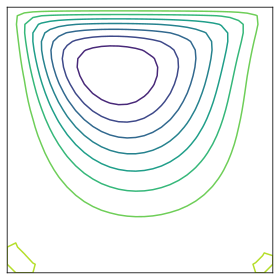

In [202]:
# Plot the streamlines
plt.contour(psisol[-1][:, ::-1])
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#plt.savefig('RE100_psi.pdf', format='pdf', bbox_inches='tight')

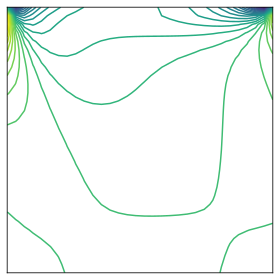

In [203]:
# Plot the vorticity
w = wsol[-1][:, ::-1]
plt.contour(w, levels=np.linspace(w.min(), w.max(), 30))
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#plt.savefig('RE100_vorticity.pdf', format='pdf', bbox_inches='tight')

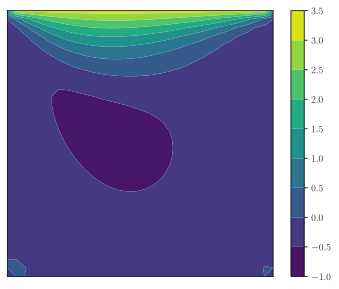

In [204]:
# Plot the velocity
u = usol[-1][:, ::-1]
plt.contourf(u)
plt.axis('square')
plt.colorbar()
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.savefig('RE100_u.pdf', format='pdf', bbox_inches='tight')

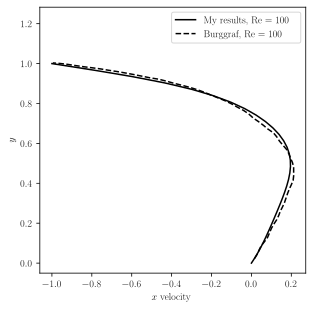

In [205]:
# U Centreline
xmax = dx*(nx-1)
ymax = dx*(ny-1)
x = np.linspace(0,xmax,nx)
y = np.linspace(0,ymax,ny) 
u_centreline = -u[0:ny,nx//2]/Ut 
plt.plot(u_centreline,y,'k',label=f'My results, Re = 100')
burggraf = pd.read_csv('vel_profiles_001.csv')
#print(burggraf)
plt.plot(burggraf['x.1'],burggraf['R100'],'k--',label='Burggraf, Re = 100')
plt.axis('square')
plt.xlabel('$x$ velocity')
plt.ylabel('$y$')
plt.legend()
plt.savefig('RE100_u.pdf', format='pdf', bbox_inches='tight')

In [206]:
# CSV save
data = np.column_stack((u_centreline, y))
np.savetxt('RE100.csv', data, fmt='%.1g', delimiter=',', header='y,u_centreline', comments='')

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.46944695e-18  0.00000000e+00]
 ...
 [ 0.00000000e+00  4.44089210e-16  0.00000000e+00 ...  0.00000000e+00
   8.88178420e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.55271368e-15
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


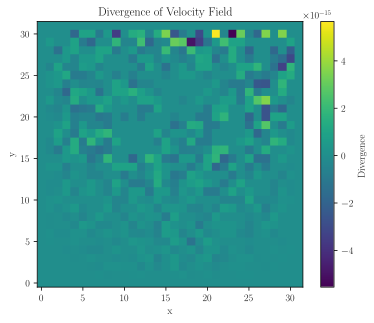

In [207]:
# Divergence of velocity
print(div)
plt.imshow(div, origin='lower', cmap='viridis')
plt.colorbar(label='Divergence')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Divergence of Velocity Field')
plt.show()

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.13638985e+00  5.91099743e+00 ...  1.55833591e+00
  -2.16153274e-02  0.00000000e+00]
 [ 0.00000000e+00  6.05537273e+00  6.29005604e+00 ...  2.94892139e-02
  -1.64433861e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00 -1.38057129e+03 -1.07709507e+03 ... -1.64257109e+02
   6.07176003e+02  0.00000000e+00]
 [ 0.00000000e+00 -3.83731816e+03 -1.91004180e+03 ... -8.72961547e+02
  -1.25079406e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


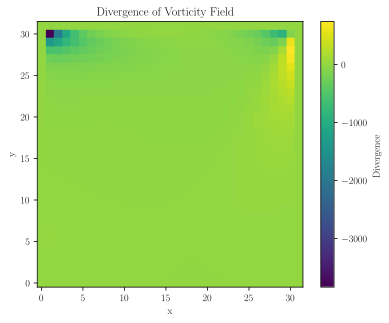

In [208]:
# Divergence of vorticity
print(div2)
plt.imshow(div2, origin='lower', cmap='viridis')
plt.colorbar(label='Divergence')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Divergence of Vorticity Field')
plt.show()

       y  u_centreline
0  -0.00          0.00
1   0.03          0.05
2   0.06          0.10
3   0.08          0.20
4   0.10          0.20
5   0.10          0.20
6   0.10          0.30
7   0.20          0.40
8   0.20          0.40
9   0.20          0.50
10  0.20          0.50
11  0.20          0.60
12  0.20          0.60
13  0.20          0.70
14  0.10          0.70
15  0.02          0.80
16 -0.10          0.80
17 -0.30          0.90
18 -0.50          0.90
19 -0.70          1.00
20 -1.00          1.00
       y  u_centreline
0  -0.00          0.00
1   0.02          0.03
2   0.04          0.06
3   0.06          0.10
4   0.07          0.10
5   0.09          0.20
6   0.10          0.20
7   0.10          0.20
8   0.10          0.30
9   0.10          0.30
10  0.20          0.30
11  0.20          0.40
12  0.20          0.40
13  0.20          0.40
14  0.20          0.50
15  0.20          0.50
16  0.20          0.50
17  0.20          0.50
18  0.20          0.60
19  0.20          0.60
20  0.10   

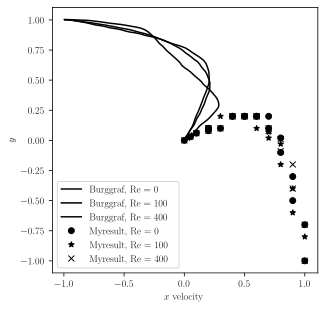

In [209]:
# Combined plot
# U Centreline
xmax = dx*(nx-1)
ymax = dx*(ny-1)
x = np.linspace(0,xmax,nx)
y = np.linspace(0,ymax,ny) 
u_centreline = -u[0:ny,nx//2]/Ut 
#plt.plot(u_centreline,y,'k',label=f'My results, Re = 400')
burggraf = pd.read_csv('vel_profiles_001.csv')
myresult1 = pd.read_csv('RE0.csv')
myresult2 = pd.read_csv('RE100.csv')
myresult3 = pd.read_csv('RE400.csv')
print(myresult1)
print(myresult2)
print(myresult3)


#print(burggraf)
plt.plot(burggraf['x'],burggraf['R0'],'k-',label='Burggraf, Re = 0')
plt.plot(burggraf['x.1'],burggraf['R100'],'k-',label='Burggraf, Re = 100')
plt.plot(burggraf['x.2'],burggraf['R400'],'k-',label='Burggraf, Re = 400')
plt.plot(myresult1['u_centreline'],myresult1['y'],'ko',label='Myresult, Re = 0')
plt.plot(myresult2['u_centreline'],myresult2['y'],'k*',label='Myresult, Re = 100')
plt.plot(myresult3['u_centreline'],myresult3['y'],'kx',label='Myresult, Re = 400')
plt.axis('square')
plt.xlabel('$x$ velocity')
plt.ylabel('$y$')
plt.legend()
plt.savefig('RE400_u.pdf', format='pdf', bbox_inches='tight')

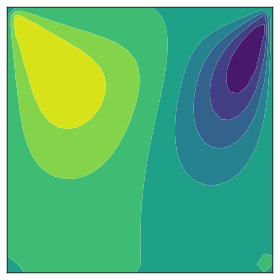

In [210]:
plt.contourf(v)
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.savefig('RE100_v.pdf', format='pdf', bbox_inches='tight')

In [211]:
end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

Execution time: 11.60 seconds
